In [27]:
import mlflow
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

True

In [3]:
df_features = pd.read_csv(config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_nodes.csv")

In [4]:
df_features.head()

,account,blockNumber_min,blockNumber_max,blockNumber_mean,gasUsed_sum,gasUsed_mean,cumulativeGasUsed_sum,cumulativeGasUsed_mean,transactionIndex_min,transactionIndex_max,...,dummy_0x1c411e9a_sum,dummy_0x9d9af8e3_sum,dummy_0x19b47279_sum,dummy_0x8201aa3f_sum,dummy_0xc42079f9_sum,dummy_0xddf252ad_sum,dummy_0x17307eab_sum,dummy_0xddac4093_sum,dummy_0x8c5be1e5_sum,dummy_0x7fcf532c_sum
0,0x00000000000124d994209fbB955E0217B5C2ECA1,16969850,17299799,1.703075e+07,1119657,101787.000000,41184266,3.744024e+06,3,48,...,3,0,0,0,5,6,0,0,3,3
1,0x000000000002e6fD89aC3B5798a5d32312B8a49f,16961029,16961029,1.696103e+07,21000,21000.000000,9850199,9.850199e+06,123,123,...,0,0,0,0,0,0,0,0,0,0
2,0x0000000000055772357E58581A2A2C5C6D9E8F64,17452199,17517647,1.748020e+07,17713256,184513.083333,194719150,2.028324e+06,0,94,...,49,0,50,0,93,96,0,0,0,0
3,0x00000000000FFE26043F4C963A16612f8410A881,16979002,16979002,1.697900e+07,132305,132305.000000,12121809,1.212181e+07,147,147,...,0,0,0,0,0,1,0,0,1,0
4,0x0000000000E3C7175357AAE6FCE025bE01Aa13Ca,17241212,17241212,1.724121e+07,21000,21000.000000,17214987,1.721499e+07,71,71,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df = df_features.drop(columns=["account", "blockNumber_max", "blockNumber_mean", "blockNumber_min", "transactionIndex_max", "transactionIndex_min", "transactionIndex_mean"])
df.head()

,gasUsed_sum,gasUsed_mean,cumulativeGasUsed_sum,cumulativeGasUsed_mean,effectiveGasPrice_mean,effectiveGasPrice_max,status_mean,fee_sum,fee_mean,account_label,...,dummy_0x1c411e9a_sum,dummy_0x9d9af8e3_sum,dummy_0x19b47279_sum,dummy_0x8201aa3f_sum,dummy_0xc42079f9_sum,dummy_0xddf252ad_sum,dummy_0x17307eab_sum,dummy_0xddac4093_sum,dummy_0x8c5be1e5_sum,dummy_0x7fcf532c_sum
0,1119657,101787.000000,41184266,3.744024e+06,3.897291e+10,62912040686,0.818182,45992942688549971,4.181177e+15,0,...,3,0,0,0,5,6,0,0,3,3
1,21000,21000.000000,9850199,9.850199e+06,2.124601e+10,21246009046,1.000000,446166189966000,4.461662e+14,0,...,0,0,0,0,0,0,0,0,0,0
2,17713256,184513.083333,194719150,2.028324e+06,4.816098e+10,809819701570,1.000000,864097987828747524,9.001021e+15,1,...,49,0,50,0,93,96,0,0,0,0
3,132305,132305.000000,12121809,1.212181e+07,2.896867e+10,28968672309,1.000000,3832700189842245,3.832700e+15,0,...,0,0,0,0,0,1,0,0,1,0
4,21000,21000.000000,17214987,1.721499e+07,1.552685e+11,155268454128,1.000000,3260637536688000,3.260638e+15,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = df.drop(columns=["account_label"])
y = df["account_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
continuous_features = [
    "gasUsed_sum",
    "gasUsed_mean",
    "cumulativeGasUsed_sum",
    "cumulativeGasUsed_mean",
    "effectiveGasPrice_mean",
    "effectiveGasPrice_max",
    "status_mean",
    "fee_sum",
    "fee_mean"
]

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(),  continuous_features)
    ],
    remainder='passthrough'
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])


param_distributions = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20, 30],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__max_features": ["sqrt", None],
}

grid_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

In [12]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               ['gasUsed_sum',
                                                                                'gasUsed_mean',
                                                                                'cumulativeGasUsed_sum',
                                                                                'cumulativeGasUsed_mean',
                                                                                'effectiveGasPrice_mean',
                                                                                'effectiveGasPrice_max',
                                                                                'status_mean',
                                                                                'fee_sum',
                                                                                'fee_mean'])])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [10, 20, 30],
                                        'classifier__max_features': ['sqrt',
                                                                     None],
                                        'classifier__min_samples_leaf': [1, 2],
                                        'classifier__min_samples_split': [2, 5],
                                        'classifier__n_estimators': [100, 200]},
                   random_state=42, verbose=2)

In [15]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE score: {-grid_search.best_score_:.3f}")

Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20}
Best RMSE score: -0.996


In [16]:
rf = grid_search.best_estimator_

In [24]:
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

Train Accuracy: 0.9996662640645858
Test Accuracy: 0.9951690821256038


In [18]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15467
           1       0.90      0.80      0.85       265

    accuracy                           1.00     15732
   macro avg       0.95      0.90      0.92     15732
weighted avg       0.99      1.00      1.00     15732



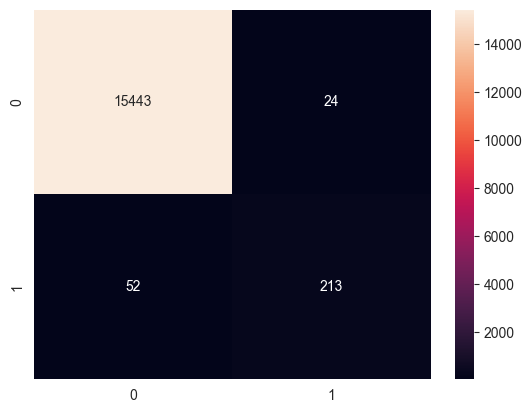

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

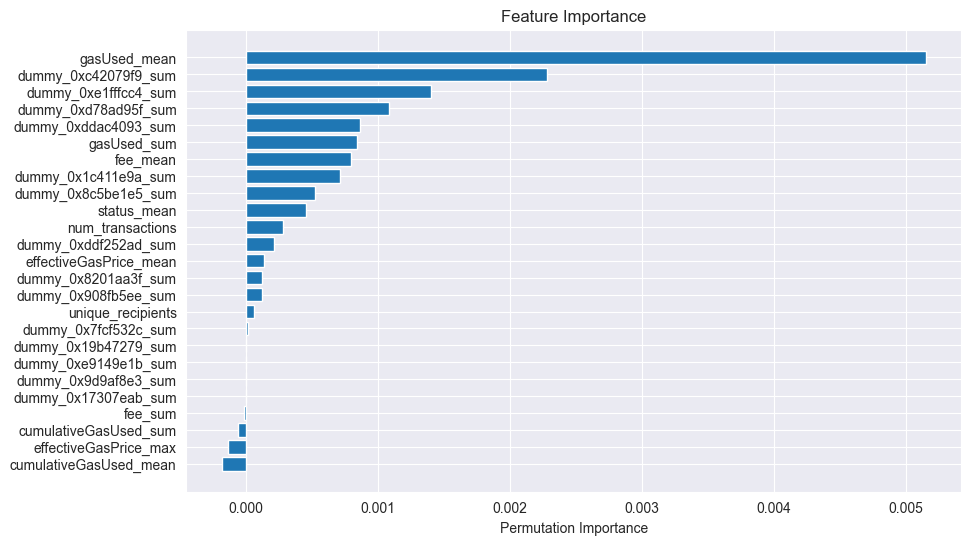

In [20]:
perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

In [28]:
mlflow.set_experiment("Node Classification")

with mlflow.start_run():
    best_model = rf
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_accuracy  = accuracy_score(y_train, y_train_pred)
    test_accuracy   = accuracy_score(y_test, y_test_pred)
    
    train_precision = precision_score(y_train, y_train_pred)
    test_precision  = precision_score(y_test, y_test_pred)
    
    train_recall    = recall_score(y_train, y_train_pred)
    test_recall     = recall_score(y_test, y_test_pred)
    
    train_f1        = f1_score(y_train, y_train_pred)
    test_f1         = f1_score(y_test, y_test_pred)
    
    train_roc_auc   = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    test_roc_auc    = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    
    mlflow.log_param("n_iter", grid_search.n_iter)
    for param, value in grid_search.best_params_.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)
    mlflow.log_metric("test_roc_auc", test_roc_auc)
    
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()
    
    report = classification_report(y_test, y_test_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv("classification_report.csv", index=True)
    mlflow.log_artifact("classification_report.csv")
    
    mlflow.sklearn.log_model(best_model, "random_forest_model")

2025/02/18 16:10:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run suave-grouse-785 at: http://127.0.0.1:8080/#/experiments/240524402154184558/runs/3a51b1c2d3fa4a2c91dfd1dfa11729cc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/240524402154184558
